In [4]:
from ansys.dpf import core as dpf

In [5]:
#dpf.connect_to_server("10.110.8.22")

2nd step : create a model

In [6]:
path =  r'c:\temp\file_static.rst'
model = dpf.Model(path)

E0114 21:47:20.833000000 21688 server_chttp2.cc:40] {"created":"@1610657240.833000000","description":"No address added out of total 1 resolved","file":"C:\.conan\9877f9d9b72\1\grpc\src\core\ext\transport\chttp2\server\chttp2_server.cc","file_line":394,"referenced_errors":[{"created":"@1610657240.833000000","description":"Failed to add port to server","file":"C:\.conan\9877f9d9b72\1\grpc\src\core\lib\iomgr\tcp_server_windows.cc","file_line":510,"referenced_errors":[{"created":"@1610657240.833000000","description":"OS Error","file":"C:\.conan\9877f9d9b72\1\grpc\src\core\lib\iomgr\tcp_server_windows.cc","file_line":201,"os_error":"Only one usage of each socket address (protocol/network address/port) is normally permitted.\r\n","syscall":"bind","wsa_error":10048}]}]}



In [7]:
mesh = model.metadata.meshed_region

In [8]:
print(model.metadata.result_info)

Static analysis
Unit system: Metric (m, kg, N, s, V, A)
Physics Type: Mecanic
Available results:
     -  displacement                  
     -  force                         
     -  stress                        
     -  volume                        
     -  energy_stiffness_matrix       
     -  hourglass_energy              
     -  thermal_dissipation_energy    
     -  kinetic_energy                
     -  co_energy                     
     -  incremental_energy            
     -  strain                        
     -  thermal_strains               
     -  thermal_strains_eqv           
     -  swelling_strains              
     -  temperature                   



## read displacements

In [9]:
displacements = model.results.displacement()

In [10]:
fields = displacements.outputs.fields_container.get_data()

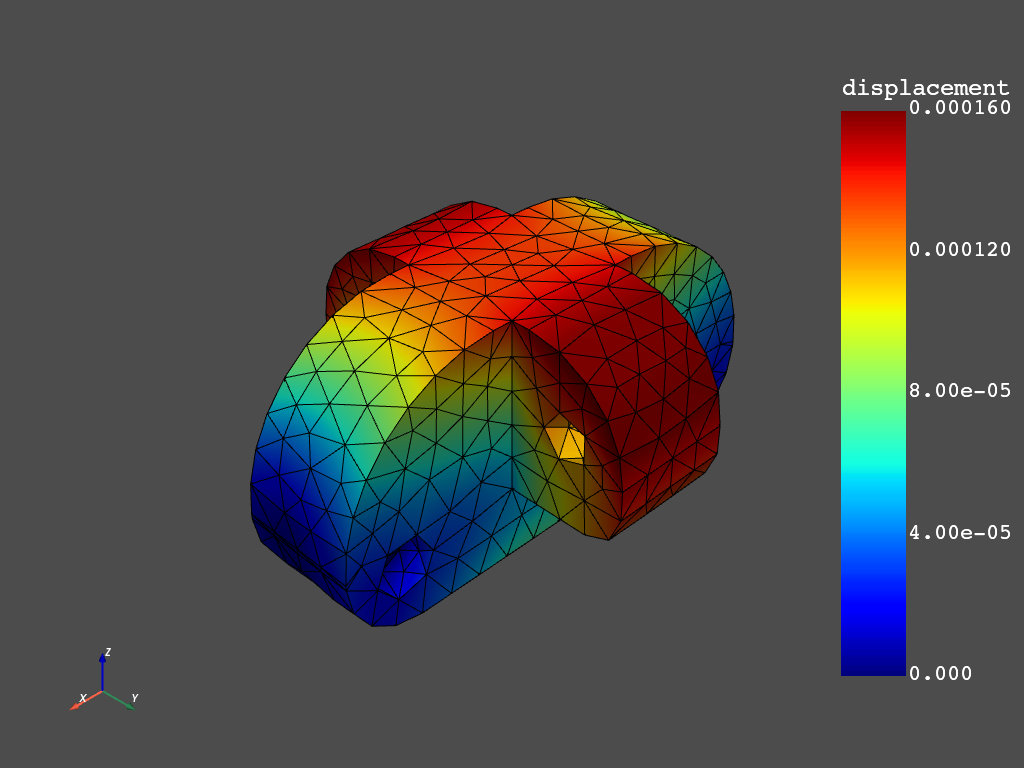

In [11]:
mesh.plot(fields)

## High pass filter

In [12]:
seqv = model.operator("S_eqv")

min_max =  model.operator('min_max_fc')
min_max.inputs.connect(seqv.outputs)

scale = model.operator('scale')
scale.inputs.ponderation.connect(0.4)
scale.inputs.field.connect(min_max.outputs.field_max)

high_pass = model.operator('core::scoping::high_pass')
high_pass.connect(0, seqv,0)
high_pass.connect(1,scale,0)

s1 = model.operator("S1")
s1.connect(1, high_pass,0)


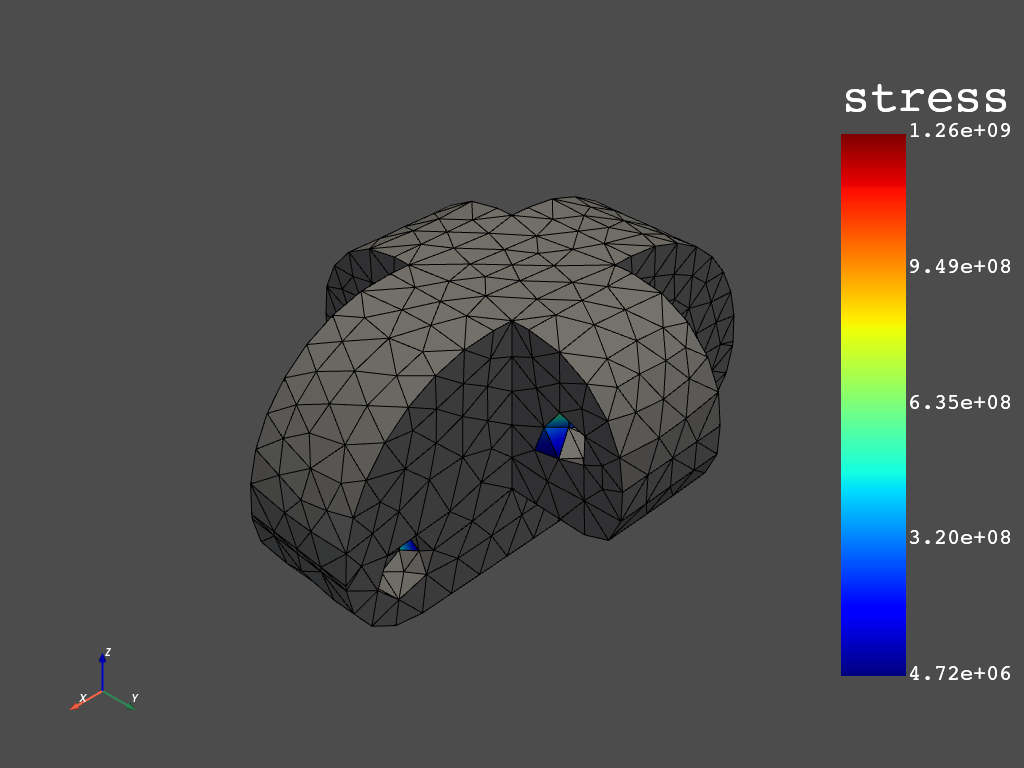

In [14]:
mesh.plot(s1.outputs.fields_container())

In [1]:
## solution combination

In [15]:
s1 = model.operator("S_eqv")
ux = model.operator("UX")

sf = ux*(1.0/0.023)
dot = s1*sf
field = dot.outputs.field()

data = field.data

for i in range(len(data)):
    value = data[i]
    if value < 300.0 and value != 0.0:
        data[i]= 300.0/value
    else:
        data[i]= 0 
field.data = data



In [16]:
field.data.max()

73.86567294332049

In [ ]:
mesh.plot(dot.outputs.field(), notebook = False)

ERROR:root:1: #version 150


## export to vtk

In [ ]:
vtk = dpf.Operator("vtk_export")

In [ ]:
vtk.inputs.file_path(r'./file.vtk')
vtk.inputs.mesh.connect(mesh)
vtk.inputs.fields1.connect(displacements.outputs.fields_container)
vtk.run()